In [1]:
#generate 50 minimal vc and pick the one with largest mass. Find sgw values afterward.

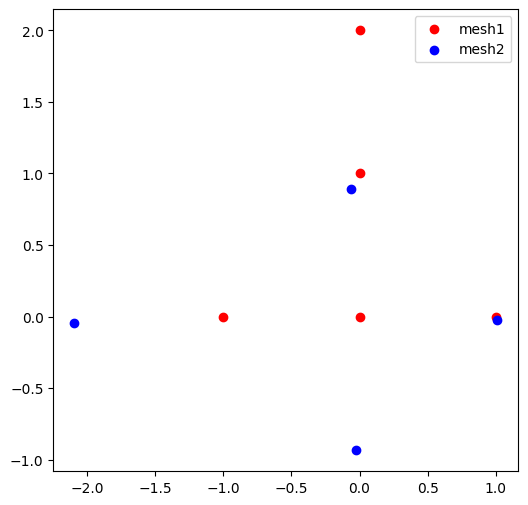

In [2]:
import itertools
import networkx as nx
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import random

# Parameters
threshold = 0.2  # Adjust threshold as needed
random_state=1
np.random.seed(random_state)
random.seed(random_state)

# Create a mesh of points
mesh1 = np.array([[0, 0], [0, 2], [1, 0], [-1, 0], [0, 1]])
mesh2 = np.array([[0, -1, 0], [0, 1, 0], [-2, 0, 0], [1, 0, 0]])
mesh2 = mesh2 + 3e-1 * (np.random.rand(*mesh2.shape) - 0.5)

plt.figure(figsize=(6, 6))
plt.scatter(mesh1[:, 0], mesh1[:, 1], color='red', label='mesh1')
plt.scatter(mesh2[:, 0], mesh2[:, 1], color='blue', label='mesh2')
plt.legend()
plt.show()

C1 = cdist(mesh1, mesh1)
C2 = cdist(mesh2, mesh2)
n = C1.shape[0]
m = C2.shape[0]

# Build graph
G = nx.Graph()
for i in range(n):
    for j in range(m):
        vertex = (i + 1, j + 1)
        G.add_node(vertex)

tensor4 = np.zeros((n, m, n, m))
C1_exp = C1[:, None, :, None]
C2_exp = C2[None, :, None, :]
tensor4 = (C1_exp - C2_exp) ** 2

positions = np.where(tensor4 > threshold ** 2)
vertex_positions = positions[0] + 1, positions[1] + 1, positions[2] + 1, positions[3] + 1

for i in range(len(positions[0])):
    first_elements = [arr[i] for arr in vertex_positions]
    vertex1 = (first_elements[0], first_elements[1])
    vertex2 = (first_elements[2], first_elements[3])
    G.add_edge(vertex1, vertex2)


In [3]:
# Function to find the vertex with most edges
def vertex_with_most_edges(graph):
    degrees = dict(graph.degree())     
    max_degree = max(degrees.values())
    max_degree_vertices = [vertex for vertex, degree in degrees.items() if degree == max_degree]

    return max_degree_vertices, max_degree

# Function to check if a set of vertices is a vertex cover
def is_vertex_cover(graph, vertices):
    covered_edges = set()
    for vertex in vertices:
        for neighbor in graph[vertex]:
            covered_edges.add(frozenset([vertex, neighbor]))
    return len(covered_edges) == graph.number_of_edges()

# Function to find the minimum vertex cover using brute-force
def minimum_vertex_cover(graph):
    vertices = list(graph.nodes)
    n = len(vertices)
    for r in range(1, n+1):
        for subset in itertools.combinations(vertices, r):
            if is_vertex_cover(graph, subset):
                return subset
    return None

# Function to check if a set is minimal
def is_minimal_vertex_cover(G, vertex_cover):
        # Check if the set covers all edges
        for u, v in G.edges():
            if u not in vertex_cover and v not in vertex_cover:
                return False  # The set does not cover all edges
        # Check for minimality
        for vertex in vertex_cover:
            # Try removing the vertex and see if it's still a vertex cover
            reduced_cover = vertex_cover - {vertex}
            if all(u in reduced_cover or v in reduced_cover for u, v in G.edges()):
                return False  # Found a smaller vertex cover
        return True  # The vertex cover is minimal

# Function to minimize vc to a minimal one
def minimize_vertex_cover(graph, initial_cover):
    """ Minimize the vertex cover """
    minimal_cover = initial_cover.copy()
    removed = True

    while removed:
        removed = False
        for vertex in list(minimal_cover):  # Create a list to avoid modifying the set during iteration
            minimal_cover.remove(vertex)
            if not is_vertex_cover(graph, minimal_cover):
                minimal_cover.add(vertex)
            else:
                removed = True  # A vertex was successfully removed

    return minimal_cover 

#Function of sOT
def perform_sOT_log(G, a, b, eps, options):

    niter = options['niter_sOT']
    # tol   = options['tol_sOT']
    f     = options['f_init']
    g     = options['g_init']
    M     = options['penalty']

    # Err = np.array([[1, 1]])

    for q in range(niter):   
        f = np.minimum(eps * np.log(a) - eps * np.log(np.sum(np.exp((f[:, None] + g[None, :]  - G) / eps), axis=1)+ 10**-20) + f, M)
        g = np.minimum(eps * np.log(b) - eps * np.log(np.sum(np.exp((f[:, None] + g[None, :]  - G) / eps), axis=0)+ 10**-20) + g, M)

    P = np.exp((f[:, None] + g[None, :] - G) / eps)
    
    return P, f, g

In [4]:
# get a list of minimal vc (not a efficient one)
def get_cover(
    D1: np.ndarray, 
    D2: np.ndarray,
    ratio: float = 0.0001,
    threshold: float = 0.02,
    random_state: int = 1,
    verbose: bool=False
):    

    np.random.seed(random_state)
    random.seed(random_state)

    n = D1.shape[0]
    m = D2.shape[0]
    C1 = D1.copy()
    C2 = D2.copy()
  
    #build graph and find an approximation of min vertex covering
    G = nx.Graph()


    tensor4 = np.zeros((n, m, n, m))

    C1_exp = C1[:, None, :, None]
    C2_exp = C2[None, :, None, :]
    tensor4 = (C1_exp - C2_exp)**2
    positions = np.where(tensor4 > threshold**2) 
    G = nx.Graph()
    G.add_edges_from(((p[0]+1, p[1]+1), (p[2]+1, p[3]+1)) for p in zip(*positions))  
    #print(f"Number of vertex: {G.number_of_nodes()}")
    
    tuples_set = set()
    B = G.copy()
    initial_random_add = int(G.number_of_nodes() * ratio)
    
    for i in range(initial_random_add):
        vertex = random.choice(list(B.nodes))
        B.remove_node(vertex)
        tuples_set.add(vertex)

    while B.edges:
        vertices, degree = vertex_with_most_edges(B)
        vertex = random.choice(vertices)
        B.remove_node(vertex)
        tuples_set.add(vertex)

        
    inf_mask = np.zeros([n, m])
    test = 0

    if is_minimal_vertex_cover(G, tuples_set):
        test = 1
        for (i, j) in tuples_set:
            inf_mask[i-1, j-1] = 1
    else:
        minimal_cover = tuples_set.copy()
        for vertex in tuples_set:
            # Remove the vertex and check if it's still a vertex cover
            minimal_cover.remove(vertex)
            if not is_vertex_cover(G, minimal_cover):
                # If not a vertex cover, add the vertex back
                minimal_cover.add(vertex)
        if is_minimal_vertex_cover(G, minimal_cover):
            test = 1
            for (i, j) in minimal_cover:
                inf_mask[i-1, j-1] = 1
        

    return inf_mask, test

0 17 0.5999999999999684 0.19430919201996838
1 18 0.399999999999979 0.834223752827759
2 17 0.5999999999999684 0.02611547477871006
3 18 0.399999999999979 0.6369770879184642
4 17 0.5999999999999684 0.39649783176853387
5 18 0.399999999999979 0.5307994680406195
6 17 0.5999999999999684 0.13345355297161254
7 17 0.5999999999999684 0.18827660448172634
8 18 0.399999999999979 0.7607272657848922
9 17 0.5999999999999684 0.9198516707758556
10 17 0.5999999999999684 0.29782162683346475
11 18 0.399999999999979 0.6577372526242814
12 18 0.399999999999979 0.8325820557660067
13 18 0.399999999999979 0.8498868696623045
14 17 0.5999999999999684 0.08088349638015203
15 17 0.5999999999999684 0.03719813859291496
16 17 0.5999999999999684 0.16142191554438398
17 18 0.399999999999979 0.8342475640075995
18 17 0.5999999999999684 0.09351965745801429
19 17 0.5999999999999684 0.40011013299229903
20 17 0.5999999999999684 0.9099992646899617
21 18 0.399999999999979 0.5065537041958689
22 18 0.399999999999979 0.657314070541554

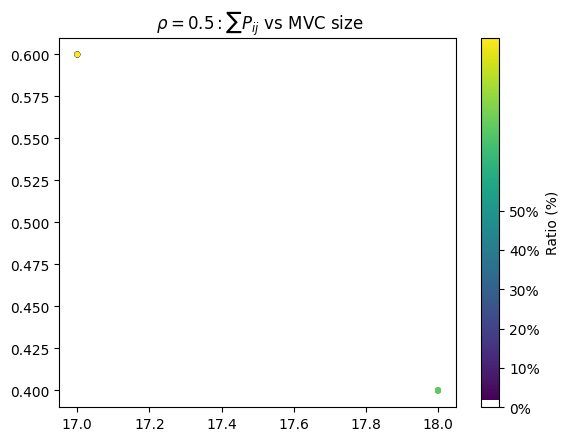

In [5]:
n_exp = 30
value = 0.2
rhos = np.full(n_exp, value)
ratios = np.random.uniform(0.0001, 0.9500, n_exp)
a = np.ones([C1.shape[0]])/C1.shape[0]
b = np.ones([C2.shape[0]])/C2.shape[0]
sot_options = {'penalty': 10, 'niter_sOT': 50000, 'f_init': np.zeros_like(a), 'g_init': np.zeros_like(b)}
A_sum_list = []
P_sum_list = []
Ratio_list = []
A_matrices_list = []

for i in range(n_exp):
    A, test = get_cover(C1, C2, threshold=rhos[i], ratio=ratios[i])
    if test == 0:
        print("error")
        break
        
    if test == 1:
        C = np.ones_like(A)
        C[np.where(A>0)] = np.inf
        P,_,_ = perform_sOT_log(C, a, b, 0.01, sot_options)
        print(i, int(A.sum()), P.sum(), ratios[i])
        A_sum_list.append(int(A.sum()))
        P_sum_list.append(P.sum())
        Ratio_list.append(ratios[i])
        A_matrices_list.append(A)
        

A_matrices_tensor = np.array(A_matrices_list)
np.save('5vs4_A_matrices_rho_0.5_0514_30.npy', A_matrices_tensor)

np.save('5vs4_A_sum_rho_0.5_0514_30.npy', A_sum_list)
np.save('5vs4_P_sum_rho_0.5_0514_30.npy', P_sum_list)
np.save('5vs4_Ratio_rho_0.5_0514_30.npy', Ratio_list)

scatter = plt.scatter(A_sum_list, P_sum_list, s=10, c=ratios)
cbar = plt.colorbar(scatter)
cbar.set_label('Ratio (%)')
cbar.set_ticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
cbar.set_ticklabels(['0%', '10%', '20%', '30%', '40%', '50%'])
plt.title(r' $\rho=0.5 : \sum P_{ij}$ vs MVC size')
plt.savefig('5vs4_MVC_rho_0.5_0514_30.png')


In [9]:
# Load the saved data
A_matrices_tensor = np.load('5vs4_A_matrices_rho_0.5_0514_30.npy')
A_sum_list = np.load('5vs4_A_sum_rho_0.5_0514_30.npy')
P_sum_list = np.load('5vs4_P_sum_rho_0.5_0514_30.npy')
Ratio_list = np.load('5vs4_Ratio_rho_0.5_0514_30.npy')

# Find the indices of the maximum value in P_sum_list
max_P_sum_value = np.max(P_sum_list)
max_indices = np.where(P_sum_list == max_P_sum_value)[0]

# Among these indices, find the one with the smallest ratio in Ratio_list
#min_ratio_index = max_indices[np.argmin(Ratio_list[max_indices])]
min_ratio_index = random.choice(max_indices)

# Get the corresponding matrix A
corresponding_A_matrix = A_matrices_tensor[min_ratio_index]

# Find the nonzero locations of the matrix A
nonzero_indices = np.argwhere(corresponding_A_matrix > 0)

# Convert the nonzero indices to a set of tuples representing the vertex cover
tuples_set = set(tuple(idx+1) for idx in nonzero_indices)

# Print the minimum vertex cover set
print(f"The index of the largest P_sum_list value is: {min_ratio_index}")
print(f"The largest P_sum_list value is: {P_sum_list[min_ratio_index]}")
print("The corresponding matrix A is:")
print(corresponding_A_matrix)
print("The minimum vertex cover set (mvc) is:")
print(tuples_set)

The index of the largest P_sum_list value is: 26
The largest P_sum_list value is: 0.5999999999999684
The corresponding matrix A is:
[[1. 1. 1. 1.]
 [1. 1. 0. 1.]
 [1. 0. 1. 1.]
 [0. 1. 1. 1.]
 [1. 1. 1. 1.]]
The minimum vertex cover set (mvc) is:
{(4, 4), (2, 4), (1, 2), (2, 1), (3, 4), (4, 3), (3, 1), (1, 1), (5, 4), (5, 1), (1, 4), (4, 2), (3, 3), (2, 2), (5, 3), (1, 3), (5, 2)}


9.653764775417999


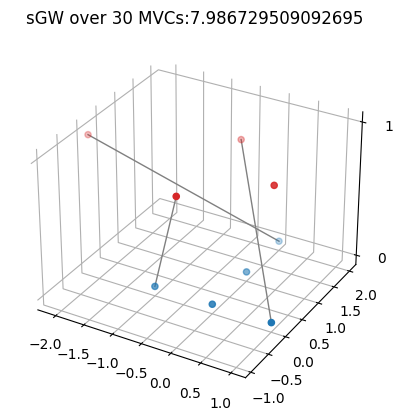

7.986729509092695


In [10]:
#####################

threshold = 0.2
gamma = 10
eps = 1e-2
eta = 1
verbose = False
nitermax = 20
#####################
a = np.array([1 / n] * n, dtype=float)
aa = a + 1e-1 * np.random.rand(n)
b = np.array([1 / m] * m, dtype=float)
bb = b + 1e-1 * np.random.rand(m)

aa = aa / np.linalg.norm((aa), ord=1)
bb = bb / np.linalg.norm((bb), ord=1)
    
#real convergence value
#eta = eps/(np.sqrt(2)* n * m * min(np.max(a), np.max(b)) * max(np.max(C1)**2,np.max(C2)**2) + eps)
    
    
P = np.outer(aa, bb) 
f = np.zeros(n)
g = np.zeros(m)
p_values = range(nitermax)
sgw_values = []

print(max(np.max(C1)**2,np.max(C2)**2))

for p in p_values:
        
    D = np.zeros((n, m)) 
    P_reshaped = P.reshape(1, 1, n, m) 
    D = np.sum(tensor4 * P_reshaped, axis=(-2, -1))
    sgw = np.sum(D * P)+gamma*(np.sum(a)+np.sum(b)-2*np.sum(P))+eps*np.sum(P * (np.log(P+10**(-20)*np.ones((n,m)))-np.ones((n,m))))
    sgw_values.append(sgw)
    
    D = 2*eta*D+eps*(eta-1)*np.log(P+10**(-20)*np.ones((n,m)))
                    
    for s, t in tuples_set:
        D[s-1, t-1] = np.inf
        
    options = {
    'niter_sOT': 10**5,
    'f_init': np.zeros(n),
    'g_init': np.zeros(m),
    'penalty': eta*gamma
    }
        
    P,f,g = perform_sOT_log(D, a, b, eps, options)

######################################################################################
#######################################################################################

def plot_mapping(P,X_1,X_2, thresh=None, linewidth=1, save_path=None):

    fig = plt.figure()
    
    ax = plt.axes(projection='3d') 
    ax.scatter3D(X_1[:,0], X_1[:,1], 0, c='tab:blue')
    ax.scatter3D(X_2[:,0], X_2[:,1], 1, c='tab:red')
    ax.set_title('sGW over 30 MVCs:' + str(sgw_values[19]))
    
    for i in range(P.shape[1]):
        if P[:,i].sum() < thresh: continue
        j = np.argmax(P[:,i])
        ax.plot3D([X_1[j,0], X_2[i,0]],[X_1[j,1], X_2[i,1]],[0,1],c='gray', linewidth=linewidth)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_zticks([0, 1])
    
        
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
plot_mapping(P, mesh1, mesh2, thresh=0.00000001, save_path='5vs4_30mvc.png')
np.savetxt('5vs4_test_30.csv', P, delimiter=',', fmt='%.10f')
print(sgw_values[19])

In [11]:
P_sum_list

array([0.6, 0.4, 0.6, 0.4, 0.6, 0.4, 0.6, 0.6, 0.4, 0.6, 0.6, 0.4, 0.4,
       0.4, 0.6, 0.6, 0.6, 0.4, 0.6, 0.6, 0.6, 0.4, 0.4, 0.6, 0.4, 0.4,
       0.6, 0.4, 0.6, 0.4])